<a href="https://colab.research.google.com/github/BastienBoucherat/geo6149/blob/main/geo6149_projet_bastien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet: Autonomie alimentaire et territoire**
GEO-6149: Géomatique

*   Bastien Boucherat (20155314)
*   Juliette Goulet ()


# **Configuration de l'environnement de travail**

## Arborescence des dossiers
Creation de quelques dossiers de travail sur Google Colab.

In [75]:
# This folder is a temporary sandbox
# Note that the content will be deleted once done
tmp_folder = "/content/tmp"
%mkdir tmp_folder

# This folder will contain the data pre-formatted for the study area
# The data is pre-processed to match the study area
data_folder = "/content/data"
%mkdir data_folder


## Installation des paquets

Installation de **GeoPandas** pour le traitement des données géospatiales

In [2]:
# Install Geopandas
%%capture
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install geopandas

Installation de **RasterIO** pour le traitement des données matricielles

In [8]:
# Install rasterIO
%%capture
!pip install rasterio

## Importation des paquets

In [3]:
# Environment
# Packages necessary to handle files in Google Colab.
import os
import os.path

In [4]:
# Data processing
import numpy as np
import pandas as pd
import geopandas as gpd

In [5]:
# Data processing: raster data
# https://rasterio.readthedocs.io/en/latest/intro.html
import rasterio
import rasterio.plot
import rasterio.mask

In [6]:
# Data format
import json

In [7]:
# Data visualisation
import matplotlib.pyplot as plt
#import contextily as cx # fond de cartes

# **Chargement des données**

## Récuperation des données distantes

In [74]:
# Load the list of remote data files
data_sources_df = pd.read_csv('/content/data_sources.csv')

In [77]:
# Remote files will be downloaded and extracted in this folder
# Then, downloaded files will be used to generate pre-processed data files eventually stored locally in another folder
%cd tmp_folder

# Download only selected data files
download_data_sources = data_sources_df[data_sources_df['Use']==True]

# For each source
for index, data_source in download_data_sources.iterrows():

    # Get the file attributes from the link
    file = data_source['Link'].split('/')[-1]
    file_name = file_name.split('.')[0]
    file_ext = file_name.split('.')[-1]

    # Download the file
    if ~os.path.isfile(file):
        print(data_source['Link'])
        !wget data_source['Link']
    
    # Extract if necessary
    if file_ext == 'zip':
        !unzip -u file -d file_name



[Errno 2] No such file or directory: 'tmp_folder'
/content/spatialindex-src-1.8.5/tmp_folder
https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lpr_000b21a_e.zip
--2023-04-07 22:01:27--  http://data_source%5Blink%5D/
Resolving data_source[link] (data_source[link])... failed: Name or service not known.
wget: unable to resolve host address ‘data_source[link]’
https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip
--2023-04-07 22:01:27--  http://data_source%5Blink%5D/
Resolving data_source[link] (data_source[link])... failed: Name or service not known.
wget: unable to resolve host address ‘data_source[link]’
https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/0_Mosaicked/ppp_2020_1km_Aggregated.tif
--2023-04-07 22:01:27--  http://data_source%5Blink%5D/
Resolving data_source[link] (data_source[link])... failed: Name or service not known.
wget: unable to resolve host address ‘data_source[link]’
https://ghsl.jrc.ec.eur

In [68]:
file_name.split('.')[0:-1]


['GHSL_data_54009_shapefile']

## Zone d'étude

Notre zone d'étude est définie par un fichier geojson.

Pour le moment, ce fichier contient une géométrie centrée sur Montréal



In [9]:
# urban_centers = ["Montreal"]
# # API Google to get the coordinate of the urban centers of our study
# 
# # Define a study zone englobing all the urban centers
#
# # Retrieve the data for the study zone

In [10]:
# Desired CRS
zone_crs = 'EPSG:4326'

# File containing the geometry of the study area
file_name = 'study_area.geojson'

In [11]:
# Load the geometry
zone_gdf = gpd.read_file(f'/content/{file_name}')

# Convert to the desired CRS
zone_gdf = zone_gdf.to_crs(zone_crs)

## Pré-traitement des données pour la zone d'étude

## Données administratives

In [33]:
# Data with KML format
import fiona

# Data file
file_name = 'canvec_admin.kml'
file_location = f'{data_path}/{file_name}'

# Load kml file
gdf = gpd.read_file(file_location, driver='KML')

DriverError: ignored

Explorer les données

0                 New Brunswick
1     Newfoundland and Labrador
2                      Manitoba
3                  Saskatchewan
4                        Quebec
5          Prince Edward Island
6                       Alberta
7              British Columbia
8                   Nova Scotia
9                       Ontario
10                        Yukon
11        Northwest Territories
12                      Nunavut
Name: Name, dtype: object


<Axes: >

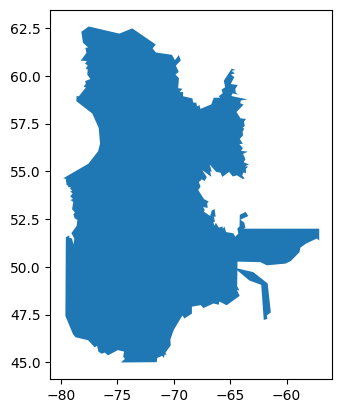

In [ ]:
# Lister les provinces
print(gdf['Name'])

# Show geometry for a Province in particular
gdf[gdf['Name']=='Quebec'].plot()

## Données matricielles de densité de population

Répartition de la population
*   Type: Carte matricielle (GeoTiff)
*   Couverture: mondiale
*   Date: 2020
*   Source: World Pop
*   Description: https://data.humdata.org/dataset/worldpop-population-counts-for-world
*   Fichier: https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/0_Mosaicked/ppp_2020_1km_Aggregated.tif



In [ ]:
# Data file
file_name = 'ppp_2020_1km_Aggregated.tif'

# Load Data file
population_raster = rasterio.open(f'{data_path}/{file_name}')

# Show some info about the data
print(population_raster.profile)
print(population_raster.shape) # quelle est la taille de l'image ?
print(population_raster.count) # quel est le nombre de couches ?
print(population_raster.bounds) # quelle est l'enmprise de la couche dans son système de coordonnées ?
print(population_raster.crs) #... d'ailleurs, quel est son système de projection ?
print(population_raster.dtypes) # quel est le type des données des pixels de l'image ?
print(population_raster.width, population_raster.height) # Largeur, hauteur

# Convert to desired CRS
if population_raster.crs != zone_crs:
   population_raster.to_crs(zone_crs)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 43200, 'height': 18720, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0083333333, 0.0, -180.001249265,
       0.0, -0.0083333333, 83.99958319871001), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
(18720, 43200)
1
BoundingBox(left=-180.001249265, bottom=-72.00041617728999, right=179.99874929500004, top=83.99958319871001)
EPSG:4326
('float32',)
43200 18720


In [ ]:
# Create a mask for RasterIO from the study zone
zone_mask = [json.loads(zone_gdf.to_json())['features'][0]['geometry']]

# clip raster
zone_population_raster = rasterio.mask.mask(population_raster, zone_mask, crop=True)

/usr/local/lib/python3.9/dist-packages/matplotlib/image.py:505: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


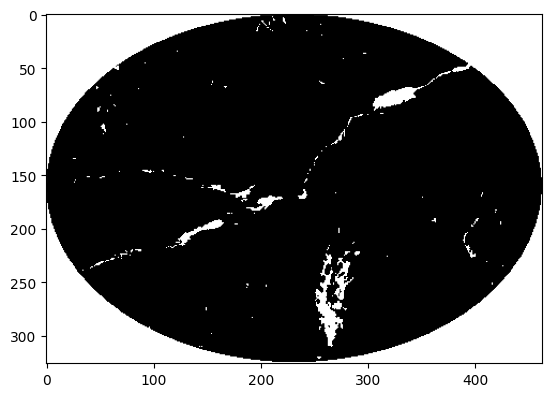

In [ ]:
# Show the data
plt.imshow(zone_population_raster[0][0], cmap='Greys')

In [ ]:
# Extract numPY array from raster
img_np = population_raster.read()

# Print some information about the array
print("Dimension de l'array :", img_np.shape)
print("La première bande :", img_np[0]) # pour accéder à la première bande
print("Les valeurs min et max des pixel de la bande :", img_np[0].min(), img_np.max()) # les valeurs minimale et maximale de la bande
print("La valeur du pixel central de la bande :", img_np[0, int(img_np[0].shape[0]/2), int(img_np[0].shape[1]/2)]) # pour accéder à tel ou tel pixel de la bande
print("La moyenne des pixels d'une bande :", np.mean(img_np[0][img_np[0] != 255])) # pour calculer des statistiques classiques sur la première bande
plt.imshow(img_np[0], cmap='Greys') # pour afficher une bande 

#plt.hist(np.histogram(img_np, bins=10, range=None, density=None, weights=None), bins='auto')

In [ ]:
x=len(zone_population_raster[0][0][0])
y=len(zone_population_raster[0][0])
print(f'x={x} y={y}')
print(len(zone_population_raster[0][0][0]))
print("Densite de population au km2 (centre de la carte):", zone_population_raster[0][0][int(y/2)][int(x/2)])

x=463 y=326
463
Densite de population au km2 (centre de la carte): 1475.3801
